# Model 1 Tvec with Log Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
#read in both datasets
harry = pd.read_csv('../Data/yer-a-wizard-Harry.csv')
starwars = pd.read_csv('../Data/Luke-After-Yoda.csv')

In [3]:
# combine harry and starwars into one DF
harry_skywalker = pd.concat([harry, starwars], axis=0)

In [4]:
harry_skywalker.head()

,Unnamed: 0,created_utc,subreddit,combo_text
0,0,1.697753e+09,HarryPotterBooks,I find the scene where Hedwig is indignant wit...
1,1,1.697736e+09,HarryPotterBooks,Polyjuice Potion - I'm reading the books again...
2,2,1.697733e+09,HarryPotterBooks,Challenged my friend to the hardest HP trivia ...
3,3,1.697726e+09,HarryPotterBooks,Sometimes it feels exhausted to love an unpopu...
4,4,1.697724e+09,HarryPotterBooks,The Trace - We know all kids under the age of ...


In [5]:
# drop Unnamed: 0 column
harry_skywalker.drop(columns = 'Unnamed: 0', inplace = True)

In [6]:
# check
harry_skywalker.head()

,created_utc,subreddit,combo_text
0,1.697753e+09,HarryPotterBooks,I find the scene where Hedwig is indignant wit...
1,1.697736e+09,HarryPotterBooks,Polyjuice Potion - I'm reading the books again...
2,1.697733e+09,HarryPotterBooks,Challenged my friend to the hardest HP trivia ...
3,1.697726e+09,HarryPotterBooks,Sometimes it feels exhausted to love an unpopu...
4,1.697724e+09,HarryPotterBooks,The Trace - We know all kids under the age of ...


In [7]:
harry_skywalker.shape

(1980, 3)

In [8]:
# double check for duplicates
harry_skywalker.duplicated().sum()

0

In [9]:
# double check for missings
harry_skywalker.isna().sum()

created_utc    0
subreddit      0
combo_text     0
dtype: int64

In [10]:
# fill missings
harry_skywalker.fillna('', inplace=True)

In [11]:
harry_skywalker.isna().sum()

created_utc    0
subreddit      0
combo_text     0
dtype: int64

In [12]:
# binarize 'subreddit' for y varibale
harry_skywalker['subreddit'] = harry_skywalker['subreddit'].map({'HarryPotterBooks': 0, 'StarWarsTheories': 1})
harry_skywalker.head()

,created_utc,subreddit,combo_text
0,1.697753e+09,0,I find the scene where Hedwig is indignant wit...
1,1.697736e+09,0,Polyjuice Potion - I'm reading the books again...
2,1.697733e+09,0,Challenged my friend to the hardest HP trivia ...
3,1.697726e+09,0,Sometimes it feels exhausted to love an unpopu...
4,1.697724e+09,0,The Trace - We know all kids under the age of ...


In [13]:
# create a column to show the length of text
harry_skywalker['length'] = harry_skywalker['combo_text'].apply(len)
harry_skywalker.head()

,created_utc,subreddit,combo_text,length
0,1.697753e+09,0,I find the scene where Hedwig is indignant wit...,615
1,1.697736e+09,0,Polyjuice Potion - I'm reading the books again...,670
2,1.697733e+09,0,Challenged my friend to the hardest HP trivia ...,887
3,1.697726e+09,0,Sometimes it feels exhausted to love an unpopu...,334
4,1.697724e+09,0,The Trace - We know all kids under the age of ...,496


In [14]:
# create a column that shows word count
harry_skywalker['word_count'] = harry_skywalker['combo_text'].apply(lambda w:len(w.split()))
harry_skywalker.head()

,created_utc,subreddit,combo_text,length,word_count
0,1.697753e+09,0,I find the scene where Hedwig is indignant wit...,615,117
1,1.697736e+09,0,Polyjuice Potion - I'm reading the books again...,670,116
2,1.697733e+09,0,Challenged my friend to the hardest HP trivia ...,887,168
3,1.697726e+09,0,Sometimes it feels exhausted to love an unpopu...,334,56
4,1.697724e+09,0,The Trace - We know all kids under the age of ...,496,88


In [15]:
#saving to reuse same df for other model
harry_skywalker.to_csv('../Data/Harry_Skywalker_Bi_Clean.csv', index =False)

In [16]:
#reading in new df as df
df = pd.read_csv('../Data/Harry_Skywalker_Bi_Clean.csv')
df.head()

,created_utc,subreddit,combo_text,length,word_count
0,1.697753e+09,0,I find the scene where Hedwig is indignant wit...,615,117
1,1.697736e+09,0,Polyjuice Potion - I'm reading the books again...,670,116
2,1.697733e+09,0,Challenged my friend to the hardest HP trivia ...,887,168
3,1.697726e+09,0,Sometimes it feels exhausted to love an unpopu...,334,56
4,1.697724e+09,0,The Trace - We know all kids under the age of ...,496,88


In [17]:
# using TF-IDF as tvec for both subreddits to take out stop words
tvec = TfidfVectorizer(stop_words='english')

In [18]:
# fitting tvec, from Lesson 505
tvec_harry = pd.DataFrame(tvec.fit_transform(df[df.subreddit==0].combo_text).todense(),
                          columns=tvec.get_feature_names_out())
tvec_harry.head()

,00,000,02,026,07,08,090,10,100,1000,...,yugoslavic,yule,z5qwyx0,zacharias,zaney,zero,zi,zograf,zoo,zuko
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111986,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15205,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0


In [19]:
tvec_luke = pd.DataFrame(tvec.fit_transform(df[df.subreddit== 1].combo_text).todense(),
                       columns=tvec.get_feature_names_out())
tvec_luke.head()

,000,032,04,05,06,0618,08,09,0bby,0m21s,...,zombified,zone,zoom,zoomed,zu,zur,zusammenhängt,ähnlichen,δαίμων,θεοί
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


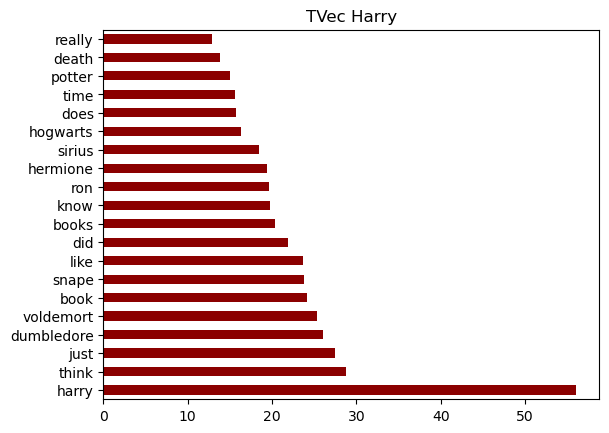

In [45]:
# find most used words in each, then plot for viz
tvec_harry.sum().sort_values(ascending =False)[:20].plot(kind = 'barh', color = 'darkred')
plt.title('TVec Harry');

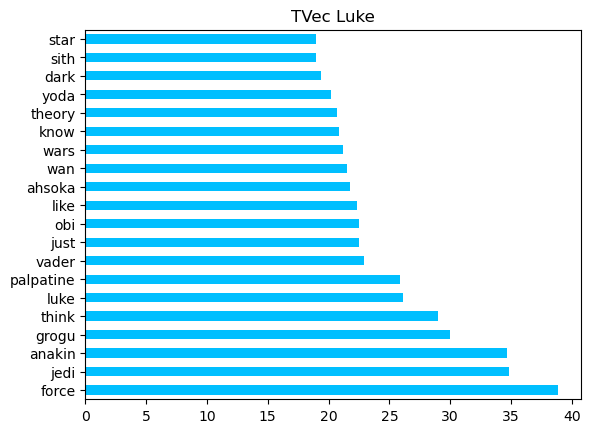

In [44]:
tvec_luke.sum().sort_values(ascending=False)[:20].plot(kind='barh', color = 'deepskyblue')
plt.title('TVec Luke');

In [22]:
#establishing X and y
X = df['combo_text']
y = df['subreddit']

In [23]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [24]:
# make a tvec for the entire X_train to see overall values
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train).todense(),columns = tvec.get_feature_names_out())
X_train_tvec

,00,000,02,026,032,04,05,06,0618,07,...,zone,zoo,zoom,zu,zuko,zur,zusammenhängt,ähnlichen,δαίμων,θεοί
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


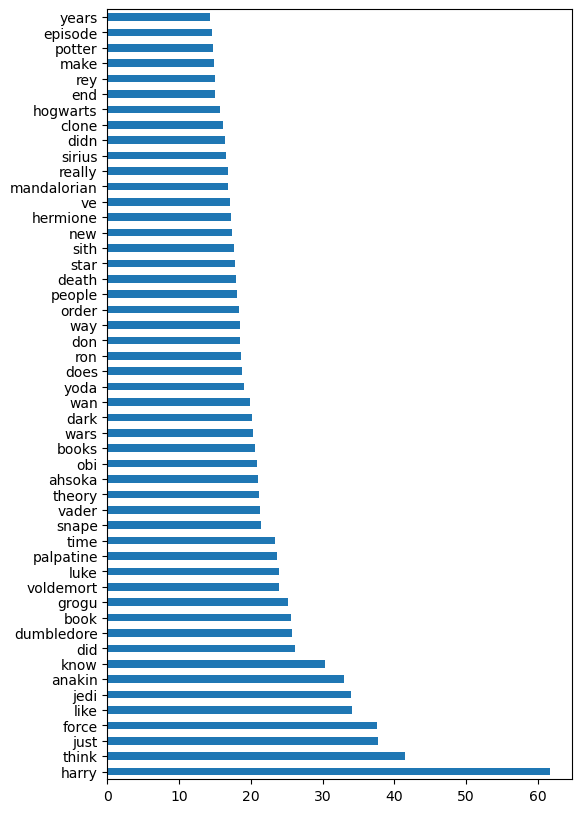

In [25]:
# top 40 words in both reddits combined
plt.figure(figsize =(6,10))
X_train_tvec.sum().sort_values(ascending=False).head(50).plot(kind='barh');

In [26]:
# make pipeline for tvec and Log Regression
log_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log', LogisticRegression())
])

In [27]:
# parameters for tvec and log regression
log_pipe.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('log', LogisticRegression())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'log': LogisticRegression(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'log__C': 1.0,
 'log__class_weight': None,
 'log__dual': False,
 'log__fit_intercept': True,
 'log__intercept_scaling': 1,
 'log__l1_ratio': None,
 'log__max_iter': 100,
 'log__multi_class': 'auto',
 'log__n_jobs': None,
 'log__penalty': 'l2',
 'log_

In [28]:
# input parameters for GridSearch
log_pipe_params = {
    'log__C': [0.1, 1, 10],
    'log__random_state': [2023],
    'tvec__max_df': [.8],
    'tvec__max_features': [3000, 6000, 9000],
    'tvec__min_df': [2]
}

In [29]:
# Instantiate GridSearch
gs_log_pipe = GridSearchCV(log_pipe,
                           param_grid = log_pipe_params,
                           cv = 5,
                           n_jobs = 4)

In [30]:
# fit GridSearch to training data
gs_log_pipe.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('log', LogisticRegression())]),
             n_jobs=4,
             param_grid={'log__C': [0.1, 1, 10], 'log__random_state': [2023],
                         'tvec__max_df': [0.8],
                         'tvec__max_features': [3000, 6000, 9000],
                         'tvec__min_df': [2]})

In [31]:
#baseline
1-y.mean()

0.5

In [32]:
# train score
gs_log_pipe.score(X_train, y_train)

1.0

In [33]:
# test score
gs_log_pipe.score(X_test, y_test)

0.9797979797979798

In [34]:
# which parameters worked best
gs_log_pipe.best_params_

{'log__C': 10,
 'log__random_state': 2023,
 'tvec__max_df': 0.8,
 'tvec__max_features': 3000,
 'tvec__min_df': 2}

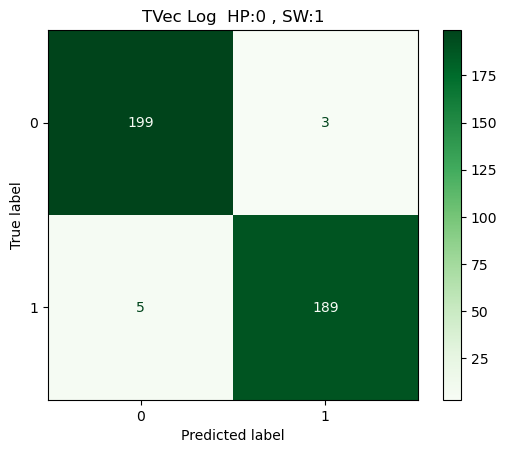

In [47]:
# make predictions and plot to a confusion matrix
preds = gs_log_pipe.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap = 'Greens')
plt.title('TVec Log  HP:0 , SW:1');

In [36]:
# view for mismatches, Help from Katie
mismatched_indices = (preds != y_test)
mismatched_texts = X_test[mismatched_indices]

for i, text in enumerate(mismatched_texts):
    predicted_label = preds[mismatched_indices][i]
    true_label = y_test.values[mismatched_indices][i]
    print(f"Predicted: {predicted_label} - Actual: {true_label}\n{text}\n")

Predicted: 0 - Actual: 1
Bullet vs blaster bolt - I’ve always wondered which travels faster a bullet or a blaster bolt. An average 9mm travels an average of 102 mph. While a bullet from an ak-47 travels 1500mph(sorry if that’s a bad comparison) and while yes it is possible to dodge a bullet in real life the blaster bolts get evaded quite easily even by regular people. So yeah. Just wondering which is faster

Predicted: 0 - Actual: 1
What do y’all think? - 

Predicted: 0 - Actual: 1
What are the Darkest starwars theories that you have read? - What are the some of the Darkest starwars theories that you have read or heard about? And what makes them so Dark and twisted?
As a bonus; What are some of the darkest starwars rewrites that you have read or heard that you have enjoyed and wished it was canon?

Predicted: 0 - Actual: 1
How would you feel about a "Tales of the Sith"? - 

Predicted: 0 - Actual: 1
I have an interesting take on my version of Episode 9! I really hope you guys read and e

### Conclusion

> This model seems like it's overfit but a it didn't miss very much. I will try to a Cvec with Random Forest to see if that is better or worse and then I will try Tvec with Random Forest to see which out of the three will be the best. Just based on what I learned and the logic I think Tvec with Random Forest will be the best model. Hot take?